In [1]:
#!pip install devito

# Part 2: Introduction to Devito

- Devito is a domain specific language (DSL) for formulating partial differential solvers in the form of finite difference operators.
- From a users perspective, they formulate the problem in a similar manner to how they would on pen and paper.
- Devito then compiles this formulation into c code optimized for the target platform.
- A main target application of Devito is producing wave-propagation kernels for use in inversion/imaging frameworks (RTM and FWI).

In this notebook we will introduce ourselves to the Devito DSL and then build a wave-propagator.

For convenience, we import all Devito modules:

In [2]:
from devito import *

# From equations to code in a few lines of Python

## Goals:

- Introduce users to some of the core *Devito* objects including grids (`Grid`), functions (`Function`, `TimeFunction`), equations (`Eq`) and operators (`Operator`)
- Illustrate how the DSL can be used to produce a range of finite difference (FD) stencils
- Execute a simple operator

The main objective of this tutorial is to demonstrate how Devito and its [SymPy](http://www.sympy.org/en/index.html)-powered symbolic API can be used to solve partial differential equations using the finite difference method with highly optimized stencils in a few lines of Python. We demonstrate how computational stencils can be derived directly from the equation in an automated fashion and how Devito can be used to generate and execute, at runtime, the desired numerical scheme in the form of optimized C code.


## Defining the physical domain

Before we can begin creating finite-difference (FD) stencils we will need to give Devito a few details regarding the computational domain within which we wish to solve our problem. For this purpose we create a `Grid` object that stores the physical `extent` (the size) of our domain and knows how many points we want to use in each dimension to discretise our data.

<img src="figures/grid.png" style="width: 320px;"/>

In [3]:
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

## Functions and data

To express our equation in symbolic form and discretise it using finite differences, Devito provides a set of `Function` types. A `Function` object:

1. Behaves like a `sympy.Function` symbol
2. Manages data associated with the symbol

To get more information on how to create and use a `Function` object, or any type provided by Devito, we can take a look at the documentation.

In [4]:
print(Function.__doc__)


    Tensor symbol representing a discrete function in symbolic equations.

    A Function carries multi-dimensional data and provides operations to create
    finite-differences approximations.

    A Function encapsulates space-varying data; for data that also varies in time,
    use TimeFunction instead.

    Parameters
    ----------
    name : str
        Name of the symbol.
    grid : Grid, optional
        Carries shape, dimensions, and dtype of the Function. When grid is not
        provided, shape and dimensions must be given. For MPI execution, a
        Grid is compulsory.
    space_order : int or 3-tuple of ints, optional
        Discretisation order for space derivatives. Defaults to 1. ``space_order`` also
        impacts the number of points available around a generic point of interest.  By
        default, ``space_order`` points are available on both sides of a generic point of
        interest, including those nearby the grid boundary. Sometimes, fewer points
        s

Ok, let's create a function $f(x, y)$ and look at the data Devito has associated with it. Please note that it is important to use explicit keywords, such as `name` or `grid` when creating `Function` objects.

In [5]:
f = Function(name='f', grid=grid)
f

f(x, y)

In [6]:
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

By default, Devito `Function` objects use the spatial dimensions `(x, y)` for 2D grids and `(x, y, z)` for 3D grids. To solve a PDE over several timesteps a time dimension is also required by our symbolic function. For this Devito provides an additional function type, the `TimeFunction`, which incorporates the correct dimension along with some other intricacies needed to create a time stepping scheme.

In [7]:
g = TimeFunction(name='g', grid=grid)
g

g(t, x, y)

Since the default time order of a `TimeFunction` is `1`, the shape of `f` is `(2, 5, 6)`, i.e. Devito has allocated two buffers to represent `g(t, x, y)` and `g(t + dt, x, y)`:

In [8]:
g.shape

(2, 5, 6)

## Forming finite difference schemes

Let us start by considering the simple example of 2D linear convection. But first, lets review some basics of finite differences.

Recall that the Taylor series of $f(x,t)$ in the spatial dimension takes the form

\begin{equation*}
 f(x+h,t)=f(x,t)+\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2+\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

We can re-arrange the above expansion in the form

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x,t)}{h}-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n.
\end{equation*}

Thus, provided $h$ is small we can say

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x+h,t)-f(x,t)}{h},
\end{equation*}

which will have an associated error

\begin{equation*}
-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n
\end{equation*}

This is the well known *forward difference* approximation (or the *right* derivative) and is how spatial derivatives are approximated in 'space order' 1 finite difference schemes.

We can also write the following Taylor expansion

\begin{equation*}
 f(x-h,t)=f(x,t)-\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2-\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

This leads to the backward difference (or *left* derivative) approximation:

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x,t)-f(x-h,t)}{h}.
\end{equation*}

In Devito, these derivatives can be represented via the following symbolic notation:

In [9]:
f.dxr # Forward difference/right derivative

Derivative(f(x, y), x)

In [10]:
f.dxl # Backward difference/left derivative

Derivative(f(x, y), x)

And to see the actual stencils they represent, we enduce the `evaluate` method:

In [11]:
f.dxr.evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

In [12]:
f.dxl.evaluate

f(x, y)/h_x - f(x - h_x, y)/h_x

which we see correspond with the expressions derived from the Taylor series above. Note that we also have access to the expression  `f.dx` which, in this particular instance, will produce a stencil equivalent to `f.dxr`. (We'll come back to this shortly when considering higher order stencils).

In [13]:
f.dx.evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

The functions we created above all act as `sympy.Function` objects, which means that we can form symbolic derivative expressions from them. Devito provides a set of shorthand expressions (implemented as Python properties) that allow us to generate finite differences in symbolic form. For example, the property `f.dx` denotes $\frac{\partial}{\partial x} f(x, y)$ - only that Devito has already discretised it with a finite difference expression.

| Derivative | Shorthand | Discretised | Stencil |
| ---------- |:---------:|:-----------:|:-------:|
| $\frac{\partial}{\partial x}f(x, y)$ (right)) | `f.dxr` | $\frac{f(x+h_x,y)}{h_x} - \frac{f(x,y)}{h_x}$ | <img src="figures/stencil_forward.png" style="width: 180px;"/> |
| $\frac{\partial}{\partial x}f(x, y)$ (left)) | `f.dxl` | $\frac{f(x,y)}{h_x} - \frac{f(x-h_x,y)}{h_x}$ | <img src="figures/stencil_backward.png" style="width: 180px;"/> |

We can form stencils for approximating the derivatives in any other spatial or time dimension in a similar manner.
Let us introduce the function $u(x,y,t)$. We have

\begin{equation*}
 \frac{\partial u}{\partial t}\approx\frac{u(x, y, t+\delta t)-u(x, y, t)}{\delta t},
\end{equation*}

where $\delta t$ is some small increment in time. This then allows us to create 'time-stepping schemes'. For example, consider the partial differential equation describing 2D linear advection

\begin{equation*}
 \frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y}=0,
\end{equation*}

discretizing only the temporal term for the time being we have

\begin{equation*}
 \frac{u(x, y, t+\delta t)-u(x, y, t)}{\delta t}+c\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right)=0,
\end{equation*}

which we can re-arrange as

\begin{equation*}
 u(x, y, t+\delta t)=u(x, y, t)-\delta tc\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right),
\end{equation*}

which is one of the most basic *explicit* time stepping schemes. Now if we approximated our spatial derivative with a backward difference approximation our scheme will become

\begin{equation*}
 u(x, y, t+\delta t)=u(x, y, t)-\delta tc\left(\frac{u(x, y, t)-u(x-h, y, t)}{h} +\frac{u(x, y, t)-u(x, y-h, t)}{h}\right).
\end{equation*}

(Note that here we have assumed an equal grid spacing $h_x=h_y=h$). Then, provided we know the status of our function $u$ at $t=0$ we can use the above scheme to compute the evolution of $u$ forward in time. Lets now implement this scheme in Devito.

We first define our grid, the function $u$ and provide an initial condition:

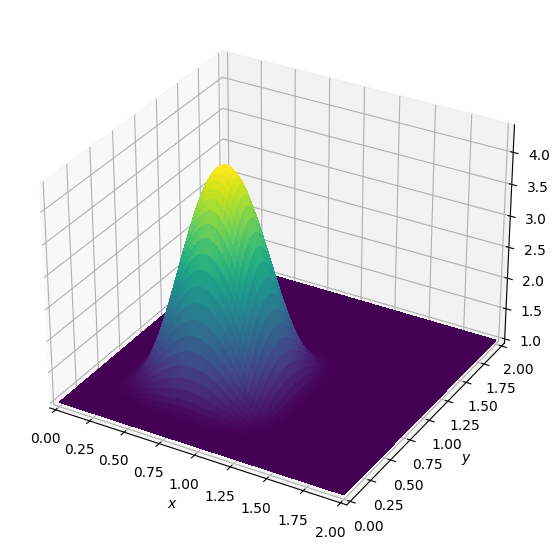

In [14]:
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=u.data[1], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])

Next we formulate our equation and finite difference scheme:

In [15]:
eq = Eq(u.dt + c * u.dxl + c * u.dyl, 0)
eq

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)

In [16]:
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(t + dt, x, y), dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt))

We can check our `update` scheme is the same as our pen and paper scheme by `evaluate`ing it:

In [17]:
update.evaluate

Eq(u(t + dt, x, y), dt*(-(u(t, x, y)/h_x - u(t, x - h_x, y)/h_x) - (u(t, x, y)/h_y - u(t, x, y - h_y)/h_y) + u(t, x, y)/dt))

Finally we need to create and execute a Devito operator. This is where the *magic* happens: Devito takes our symbolic specification of the boundary value problem and through a number of compilation passes produces c code optimised for the target platform. We'll talk more about `Operator` objects in the following section, for now we'll just utilize it

Operator `Kernel` ran in 0.01 s


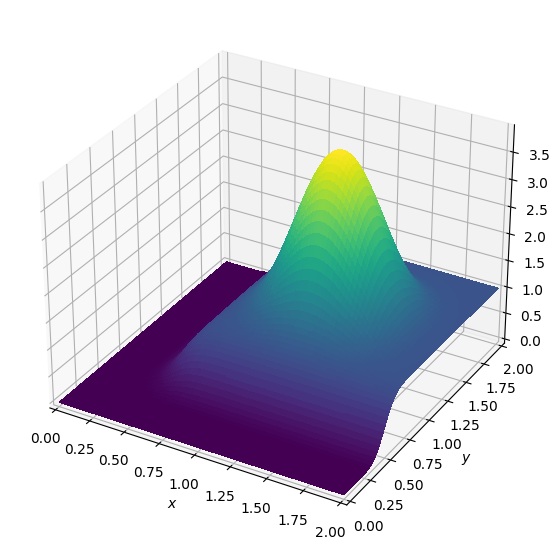

In [18]:
op = Operator(update)
op(time=nt+1, dt=dt)

plot_field(u.data[0])

We can view the generated c code via

In [19]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  /* Flush denormal numbers to zero in hardware */
  

There also exist a range of other convenient shortcuts. For example, the forward and backward stencil points, `g(t+dt, x, y)` and `g(t-dt, x, y)`.

In [20]:
g.forward

g(t + dt, x, y)

In [21]:
g.backward

g(t - dt, x, y)

And of course, there's nothing to stop us taking derivatives on these objects:

In [22]:
g.forward.dt

Derivative(g(t + dt, x, y), t)

In [23]:
g.forward.dy

Derivative(g(t + dt, x, y), y)

## Second derivatives and high-order stencils

The logic for constructing derivatives and finite difference schemes introduced above carries over higher order derivatives and higher order approximations in a straightforward manner. For example, second derivative with respect to $x$ of order two,

\begin{equation*}
  \frac{\partial^2 f}{\partial x^2}=\frac{f(x-h,t)-2f(x,t)+f(x+h,t)+\mathcal{O}(h^3)}{h^2},
\end{equation*}

can be implemented via `f.dx2`.

In [24]:
f = Function(name='f', grid=grid, space_order=2)

In [25]:
f.dx2.evaluate

-2.0*f(x, y)/h_x**2 + f(x - h_x, y)/h_x**2 + f(x + h_x, y)/h_x**2

And if, for example, we wish to produce fourth order accurate first derivatives

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{\frac{1}{12}f(x-2h,t)-\frac{2}{3}f(x-h,t)+\frac{2}{3}f(x+h,t)-\frac{1}{12}f(x+2h,t)+\mathcal{O}(h^5)}{h},
\end{equation*}

we can do so in the following manner:

In [26]:
f = Function(name='f', grid=grid, space_order=4)
f.dx.evaluate

0.0833333333*f(x - 2*h_x, y)/h_x - 0.666666667*f(x - h_x, y)/h_x + 0.666666667*f(x + h_x, y)/h_x - 0.0833333333*f(x + 2*h_x, y)/h_x

By default, Devito will produce schemes with the order `space_order` used when defining a `Function`.

We can override this by explicitly passing the space order of the desired scheme when creating a symbolic expression for a derivative. For example:

In [27]:
f.dx(fd_order=2).evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

Note that `fd_order` cannot exceed the `space_order` with which a `Function` was defined.

Time derivatives follow a similar principle, we simply instead pass the desired `time_order` to a function, e.g.,

In [28]:
g = TimeFunction(name='g', grid=grid, time_order=2, space_order=4)

In [29]:
g.dt2.evaluate+g.dy.evaluate

-2.0*g(t, x, y)/dt**2 + g(t - dt, x, y)/dt**2 + g(t + dt, x, y)/dt**2 + 0.0833333333*g(t, x, y - 2*h_y)/h_y - 0.666666667*g(t, x, y - h_y)/h_y + 0.666666667*g(t, x, y + h_y)/h_y - 0.0833333333*g(t, x, y + 2*h_y)/h_y

To implement the diffusion or wave equations, we must take the Laplacian $\nabla^2 u$, which is the sum of the second derivatives in all spatial dimensions. For this, Devito also provides a shorthand expression, which means we do not have to hard-code the problem dimension (2D or 3D) in the code. To change the problem dimension we can create another `Grid` object and use this to re-define our `Function`'s:

In [30]:
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))

u = TimeFunction(name='u', grid=grid_3d, space_order=2)
u

u(t, x, y, z)

We can re-define our function `u` with a different `space_order` argument to change the discretisation order of the stencil expression created. For example, we can derive an expression of the 12th-order Laplacian $\nabla^2 u$:

In [31]:
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

The same expression could also have been generated explicitly via:

In [32]:
u.dx2 + u.dy2 + u.dz2

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

## Derivatives of composite expressions

Derivatives of any arbitrary expression can easily be generated:

In [33]:
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2, time_order=2)

In [34]:
v.dt2 + u.laplace

Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2))

In [35]:
(v.dt2 + u.laplace).dx2

Derivative(Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2)), (x, 2))

Which can, depending on the chosen discretisation, lead to fairly complex stencils: 

In [36]:
(v.dt2 + u.laplace).dx2.evaluate

-2.0*(-2.0*v(t, x, y)/dt**2 + v(t - dt, x, y)/dt**2 + v(t + dt, x, y)/dt**2 - 2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2 - 2.0*u(t, x, y)/h_y**2 + u(t, x, y - h_y)/h_y**2 + u(t, x, y + h_y)/h_y**2)/h_x**2 + (-2.0*v(t, x - h_x, y)/dt**2 + v(t - dt, x - h_x, y)/dt**2 + v(t + dt, x - h_x, y)/dt**2 + u(t, x, y)/h_x**2 + u(t, x - 2*h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_y**2 + u(t, x - h_x, y - h_y)/h_y**2 + u(t, x - h_x, y + h_y)/h_y**2)/h_x**2 + (-2.0*v(t, x + h_x, y)/dt**2 + v(t - dt, x + h_x, y)/dt**2 + v(t + dt, x + h_x, y)/dt**2 + u(t, x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_x**2 + u(t, x + 2*h_x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_y**2 + u(t, x + h_x, y - h_y)/h_y**2 + u(t, x + h_x, y + h_y)/h_y**2)/h_x**2

# Introduction to seismic modelling - 2D acoustic propagator

## Goals

- Introduce the seismic `Model` class
- Introduce 'sources' and 'receivers' (sparse operations)
- Build an acoustic forward propagator

## Modelling workflow

The core process we are aiming to model is a seismic survey, which consists of two main components:

- **Source** - A source is positioned at a single or a few physical locations where artificial pressure is injected into the domain we want to model. In the case of land survey, it is usually dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
- **Receiver** - A set of microphones or hydrophones are used to measure the resulting wave and create a set of measurements called a *Shot Record*. These measurements are recorded at multiple locations, and usually at the surface of the domain or at the bottom of the ocean in some marine cases.

In order to create a numerical model of a seismic survey, we need to solve the wave equation and implement source and receiver interpolation to inject the source and record the seismic wave at sparse point locations in the grid.


<img src='./figures/survey-ship-diagram.png' width=400>

## The acoustic seismic wave equation
The acoustic wave equation for the square slowness $m$, defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by:

\begin{cases}
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) = q \ \text{in } \Omega \\
 &u(\mathbf{x},0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}

with the zero initial conditions to guarantee unicity of the solution.
The boundary conditions are Dirichlet conditions:
\begin{equation}
 u(\mathbf{x},t)|_{\delta\Omega} = 0
\end{equation}

where $\delta\Omega$ is the surface of the boundary of the model $\Omega$.


# Finite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagates in every direction to an ''infinite'' distance. However, solving the wave equation in a mathematically/discrete infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or Perfectly Matched Layers (PML) are required to mimic an infinite domain. These two methods allow us to approximate an unbounded media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. (Note that we will explore the implementation of a more sophisticated boundary condition in the following notebook).The core idea is to extend the physical domain and to add a *sponge mask* in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) + \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=q  \ \text{in } \Omega \\
 &u(\mathbf{x},0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask which is equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choice of profile can be chosen for $\eta$ from, e.g., linear to exponential.

# Seismic modelling with devito

We describe here a step by step setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a single source along with a set of receivers. But first, we initialize some basic utilities.

In [37]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Define the physical problem

The first step is to define the physical model:

- What are the physical dimensions of interest
- What is the velocity profile of this physical domain

We will create a simple velocity model here by hand for demonstration purposes. This model essentially consists of two layers, each with a different velocity: $1.5km/s$ in the top layer and $2.5km/s$ in the bottom layer. We will use this simple model a lot in the following tutorials, so we will rely on a utility function to create it again later.

/home/rhodri/environments/devito_pip/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/rhodri/environments/devito_pip/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


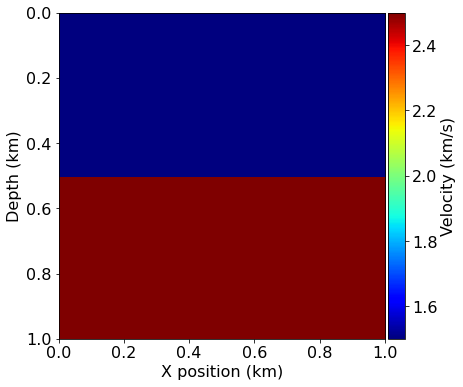

In [38]:
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

# Acquisition geometry

To fully define our problem setup we also need to define the source that injects the wave to the model and the set of receiver locations at which to the wavefield is sampled. The source time signature will be modelled using a 'Ricker' wavelet whose form is defined as

\begin{equation}
  q(t) = (1-2\pi^2 f_0^2 (t - \frac{1}{f_0})^2 )e^{- \pi^2 f_0^2 (t - \frac{1}{f_0})}.
\end{equation}

To include such a source signature in our model we first need to define the time duration of our model and the timestep size, which is dictated by the CFL condition and our grid spacing. Luckily, our `Model` utility provides us with the critical timestep size, so we can fully discretize our model time axis as an array:

In [39]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

Recall that we can view the documentation for the `TimeAxis` object (or any other object via):

In [40]:
print(time_range.__doc__)


    Data object to store the TimeAxis. Exactly three of the four key arguments
    must be prescribed. Because of remainder values it is not possible to create
    a TimeAxis that exactly adhears to the inputs therefore start, stop, step
    and num values should be taken from the TimeAxis object rather than relying
    upon the input values.

    The four possible cases are:
    start is None: start = step*(1 - num) + stop
    step is None: step = (stop - start)/(num - 1)
    num is None: num = ceil((stop - start + step)/step);
                 because of remainder stop = step*(num - 1) + start
    stop is None: stop = step*(num - 1) + start

    Parameters
    ----------
    start : float, optional
        Start of time axis.
    step : float, optional
        Time interval.
    num : int, optional
        Number of values (Note: this is the number of intervals + 1).
        Stop value is reset to correct for remainder.
    stop : float, optional
        End time.
    


(Note: Values of the time steps are stored in `time_range.time_values`.)

We position the source at a depth of $20m$ and in the center of the $x$ axis ($\mathbf{x}_{src}=(500m, 20m)$), with a peak wavelet frequency of $10Hz$.

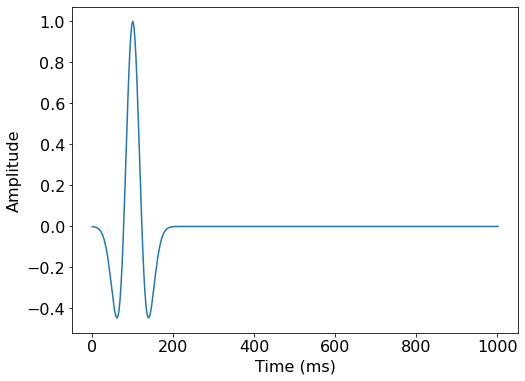

In [41]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] = np.array(model.domain_size[0]) * .5
src.coordinates.data[0, 1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet via:
src.show()

Similarly to our source object, we can now define our receiver geometry as a symbol of type `Receiver`. It is worth noting here that both utility classes, `RickerSource` and `Receiver` are thin wrappers around Devito's `SparseTimeFunction` type, which encapsulates sparse point data and allows us to inject and interpolate values into and out of the computational grid. As we have already seen, both types provide a `.coordinates` property to define the position within the domain of all points encapsulated by that symbol. 

In this example we will position receivers at the same depth as the source, every $10m$ along the x axis. The `rec.data` property will be initialized, but left empty, as we will compute the receiver readings during the simulation.

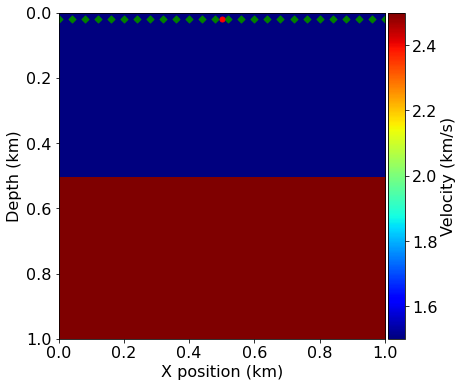

In [42]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

# Finite-difference discretization

The finite-difference approximation is derived from Taylor expansions of the continuous field after removing the error term.

## Time discretization

We only consider the second order time discretization for now. From the Taylor expansion, the second order discrete approximation of the second order time derivative is:
\begin{equation}
\begin{aligned}
 \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} = \frac{\mathbf{u}(\mathbf{x},\mathbf{t+\Delta t}) - 2 \mathbf{u}(\mathbf{x},\mathbf{t}) + \mathbf{u}(\mathbf{x},\mathbf{t-\Delta t})}{\mathbf{\Delta t}^2} + O(\mathbf{\Delta t}^2).
\end{aligned}
\end{equation} 

where $\mathbf{u}$ is the discrete wavefield, $\mathbf{\Delta t}$ is the discrete
time-step (distance between two consecutive discrete time points) and $O(\mathbf{\Delta
  t}^2)$ is the temporal discretization error term. The discretized approximation of the
second order time derivative is then given by dropping the error term. This derivative is represented in Devito by `u.dt2` where u is a `TimeFunction` object.

## Spatial discretization 

We define the discrete Laplacian as the sum of the second order spatial
derivatives in the three dimensions:
\begin{equation}
\begin{aligned}
\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t})= \sum_{j=1}^{j=\frac{k}{2}} \Bigg[\alpha_j \Bigg(&
\mathbf{u}(\mathbf{x+jdx},\mathbf{y},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x-jdx},\mathbf{y},\mathbf{z},\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y+jdy},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y-jdy},\mathbf{z}\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z+jdz},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z-jdz},\mathbf{t})\Bigg) \Bigg] + \\
&3\alpha_0 \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}).
\end{aligned}
\end{equation}

where $\alpha_j$ are the appropriate finite difference weights for the approximation. This derivative is represented in Devito by `u.laplace`.

## Wave equation

With the space and time discretization defined, we can fully discretize the wave-equation with the combination of time and space discretizations and obtain the following second order in time and $k^{th}$ order in space discrete stencil to update one grid point at position $\mathbf{x}, \mathbf{y},\mathbf{z}$ at time $\mathbf{t}$, i.e.
\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

In [43]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [44]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

# Source injection and receiver interpolation

With a numerical scheme to solve the homogenous wave equation, we need to add the source to introduce seismic waves and to implement the measurement operator, and interpolation operator. This operation is linked to the discrete scheme and needs to be done at the proper time step. The semi-discretized in time wave equation with a source reads:

\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

It shows that in order to update $\mathbf{u}$ to the time $\mathbf{t+\Delta t}$ we must inject the value of the source term $\mathbf{q}$ at time $\mathbf{t}$. In Devito, this corresponds to the update of $u$ at index $t+1$ (t = time implicitly) with the source of time $t$.

In [45]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

# Devito operator and solve
After constructing all the necessary expressions for updating the wavefield, injecting the source term and interpolating onto the receiver points, we can now create the Devito operator that will generate the C code at runtime. When creating the operator, Devito's two optimization engines will log which performance optimizations have been performed:
* **DSE:** The Devito Symbolics Engine will attempt to reduce the number of operations required by the kernel.
* **DLE:** The Devito Loop Engine will perform various loop-level optimizations to improve runtime performance.

**Note**: The argument `subs=model.spacing_map` causes the operator to substitute values for our current grid spacing into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coefficients.

In [46]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`. First, lets run for a few timesteps and visualize the wave-field:

In [47]:
op(time=100, dt=model.critical_dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.002516, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4.9999999999999996e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00020399999999999965, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

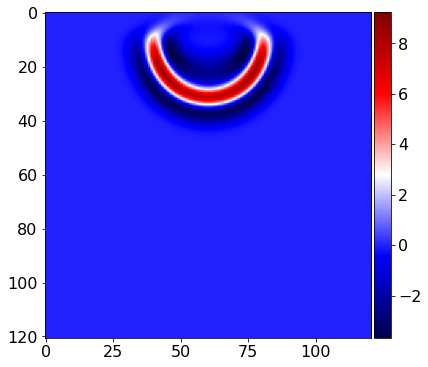

In [48]:
from examples.seismic import plot_image
plot_image(u.data[0, :, :], cmap="seismic")

Then, lets reset the wavefield and run the simulation for the full duration:

In [49]:
u.data[:] = 0.0
op(time=time_range.num-1, dt=model.critical_dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.007876000000000008, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2.4000000000000007e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0006310000000000043, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

After running our operator kernel, the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

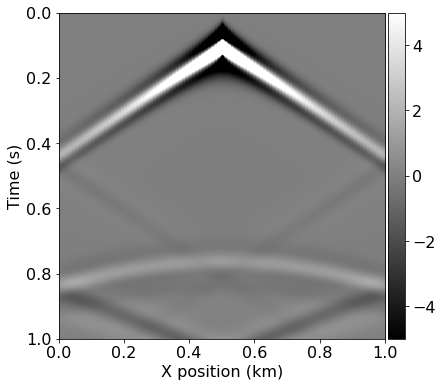

In [50]:
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)